In [1]:
import pandas as pd
import regex as re
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from flair.models import SequenceTagger
from flair.data import Sentence

c:\Users\User\Documents\Code\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/clean/clean_dataset.csv')
df.head()

name  name_length  \
0   Gamis Pria Dewasa Premium / Jubah Pakistan Polos           38   
1  Buket Bunga Mawar Flanel / Bunga wisuda / Bung...           11   
2  Mika Sen Depan Supra Fit New Kaca Lampu Sein D...           10   
3  Blazer wanita jumbo big size stik balik / plus...           24   
4  Buku Ilmu Sosial Budaya Dasar Perspektif Baru ...           69   

                                          clean_name  \
0     gamis pria dewasa premium jubah pakistan polos   
1  buket bunga mawar flanel bunga wisuda bunga so...   
2  mika sen depan supra fit new kaca lampu sein d...   
3  blazer wanita jumbo big size stik balik plus s...   
4  buku ilmu sosial budaya dasar perspektif baru ...   

                                             noun_id  \
0                  gamis pria premium jubah pakistan   
1           buket bunga mawar flanel wisuda souvenir   
2  mika sen depan supra fit new kaca lampu sein d...   
3     blazer wanita jumbo size stik balik plus outer   
4   buku ilmu sosial budaya perspektif kesadaran ani   

                                             en_noun  \
0     gamis pria dewasa premium jubah pakistan polos   
1                                        buket bunga   
2                                         mika motor   
3                blazer wanita jumbo size stik balik   
4  buku ilmu sosial budaya dasar perspektif baru ...   

                                           dual_noun  \
0     gamis pria premium jubah pakistan dewasa polos   
1           buket bunga mawar flanel wisuda souvenir   
2  mika sen depan supra fit new kaca lampu sein d...   
3     blazer wanita jumbo size stik balik plus outer   
4   buku ilmu sosial budaya perspektif kesadaran ani   

                                       clean_en_noun  
0             gamis pria dewasa jubah pakistan polos  
1                                        buket bunga  
2                                         mika motor  
3                           blazer wanita stik balik  
4  buku ilmu sosial budaya dasar perspektif baru ...

In [3]:
df.dropna(subset=['clean_en_noun'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8060 entries, 0 to 8060
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           8060 non-null   object
 1   name_length    8060 non-null   int64 
 2   clean_name     8060 non-null   object
 3   noun_id        8060 non-null   object
 4   en_noun        8060 non-null   object
 5   dual_noun      8060 non-null   object
 6   clean_en_noun  8060 non-null   object
dtypes: int64(1), object(6)
memory usage: 503.8+ KB


In [4]:
# List min_df dan range klaster
min_list = [5, 10, 20, 30, 40, 50]
range_list = [range(2, 20), range(100, 120), range(500, 520), range(1000, 1020)]
results = []  # List untuk menyimpan hasil eksperimen

In [5]:
# Fungsi untuk melakukan eksperimen
def clustering_experiment(df, min_list, range_list):
    for min_df in min_list:
        print(f"Evaluating min_df={min_df}...")
        # TF-IDF Vectorization
        vectorizers = {
            'basic_preprocessing': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['clean_name']),
            'stanza_id': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['noun_id']),
            'stanza_en': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['en_noun']),
            'stanza_multi': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['dual_noun']),
            'stanza_en_v2': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['clean_en_noun'])
        }

        for name, data in vectorizers.items():
            for cluster_range in range_list:
                silhouette_scores = []
                for n_clusters in cluster_range:
                    # K-Means clustering
                    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                    labels = kmeans.fit_predict(data)
                    score = silhouette_score(data, labels)
                    silhouette_scores.append(score)
                
                # Simpan hasil eksperimen
                avg_score = sum(silhouette_scores) / len(silhouette_scores)
                results.append({
                    'model_noun': name,
                    'min_df': min_df,
                    'cluster_range': f"{cluster_range.start}-{cluster_range.stop - 1}",
                    'avg_silhouette_score': avg_score
                })

# Jalankan eksperimen
clustering_experiment(df, min_list, range_list)

Evaluating min_df=5...
Evaluating min_df=10...
Evaluating min_df=20...
Evaluating min_df=30...
Evaluating min_df=40...
Evaluating min_df=50...


In [6]:
results_df = pd.DataFrame(results)

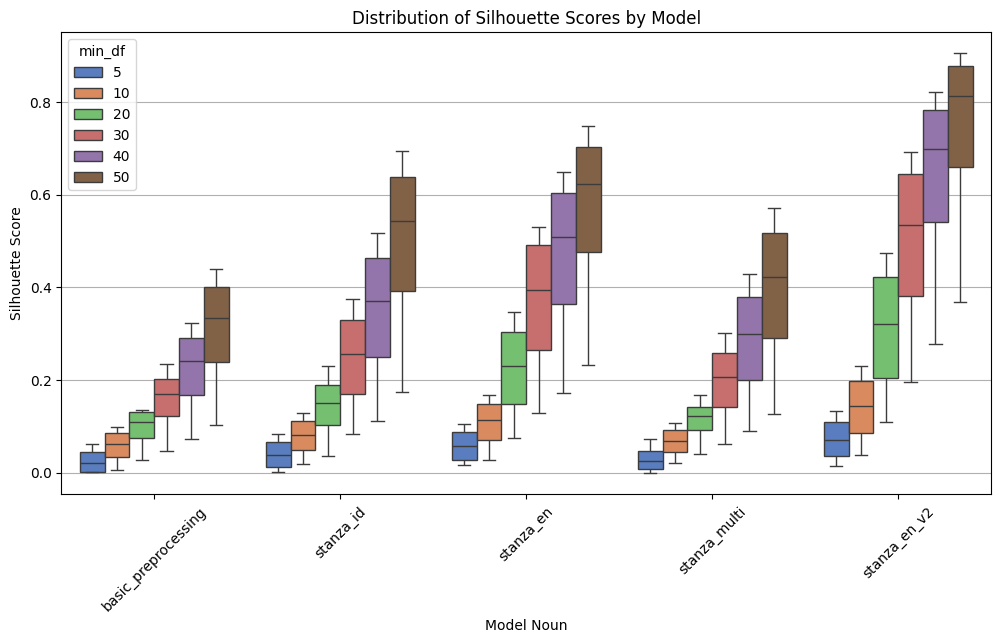

In [7]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df,
    x='model_noun',
    y='avg_silhouette_score',
    palette='muted',
    hue='min_df'
)
plt.title("Distribution of Silhouette Scores by Model")
plt.xlabel("Model Noun")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


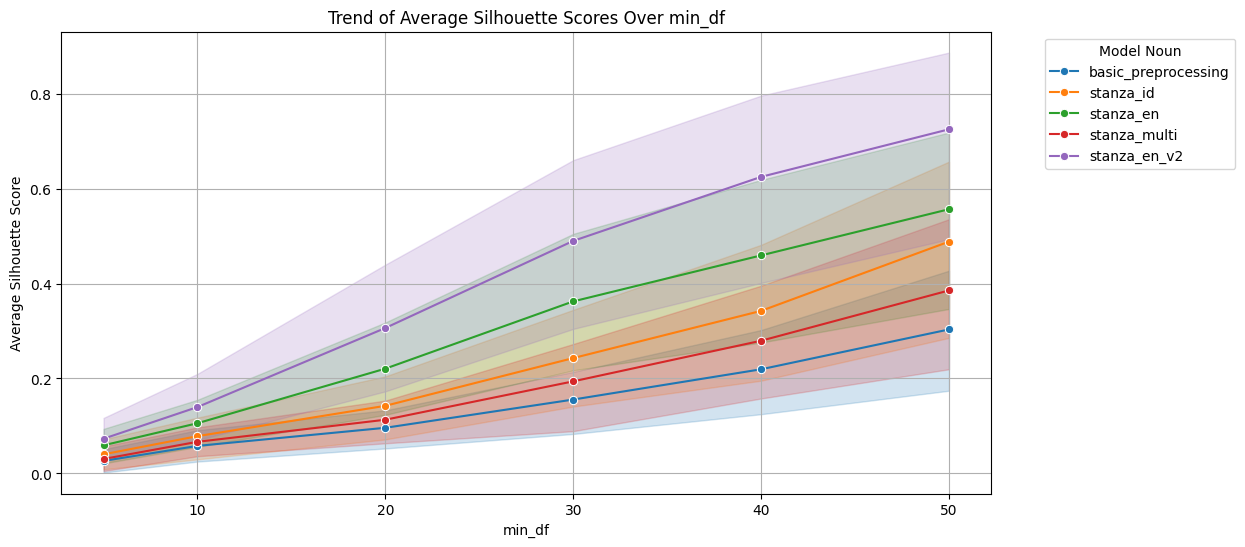

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='min_df',
    y='avg_silhouette_score',
    hue='model_noun',
    marker='o',
    palette='tab10'
)
plt.title("Trend of Average Silhouette Scores Over min_df")
plt.xlabel("min_df")
plt.ylabel("Average Silhouette Score")
plt.legend(title="Model Noun", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


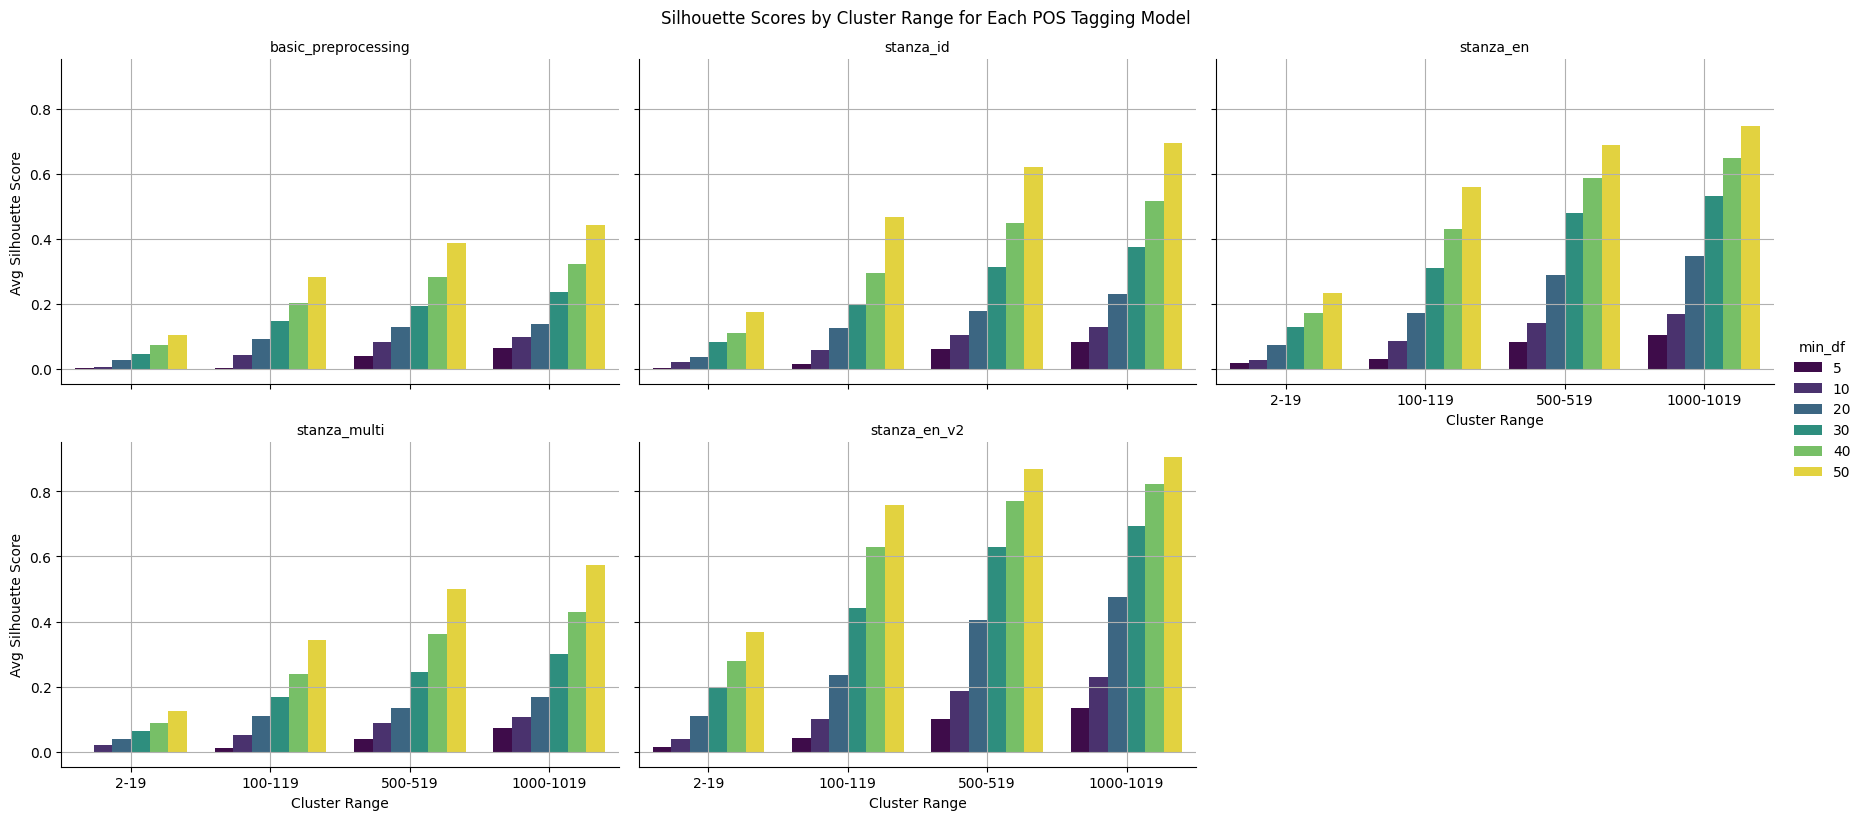

In [9]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="avg_silhouette_score", palette="viridis", hue="min_df")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Avg Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
g.add_legend(title="min_df")
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

# BEST MODEL IS STANZA_EN

In [12]:
vectorizers = {
    'basic_preprocessing': TfidfVectorizer(max_df=0.95, min_df=40, stop_words='english').fit_transform(df['clean_name']),
    'stanza_id': TfidfVectorizer(max_df=0.95, min_df=40, stop_words='english').fit_transform(df['noun_id']),
    'stanza_en': TfidfVectorizer(max_df=0.95, min_df=40, stop_words='english').fit_transform(df['en_noun']),
    'stanza_multi': TfidfVectorizer(max_df=0.95, min_df=40, stop_words='english').fit_transform(df['dual_noun']),
    'stanza_en_v2': TfidfVectorizer(max_df=0.95, min_df=40, stop_words='english').fit_transform(df['clean_en_noun'])
}

In [10]:
def show_cluster(column_name, cluster_number, cluster_end: int = None):
    if cluster_end is None:
        cluster_end = cluster_number
        cluster_number = 0
    pd.set_option('display.max_colwidth', None)

    # Show some product examples from each cluster
    for n_clusters in range(cluster_number, cluster_end):
        print(f"\nExamples of products in Cluster {n_clusters}:")
        print(df[df[column_name] == n_clusters][['name']].head(5))

    # Reset display option
    pd.reset_option('display.max_colwidth')

In [13]:
from wordcloud import WordCloud

def show_wordclouds(column_name, cluster_number, cluster_end: int = None):
    if cluster_end is None:
        cluster_end = cluster_number
        cluster_number = 0
    for n_clusters in range(cluster_number, cluster_end):
        # Ambil teks dari cluster tertentu
        cluster_data = df[df[column_name] == n_clusters]['name'].dropna().tolist()
        text = " ".join(cluster_data)  # Gabungkan semua teks dalam cluster

        # Buat WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Tampilkan WordCloud
        plt.figure(figsize=(6, 3))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for Cluster {n_clusters}", fontsize=16)
        plt.show()

## CLUSTERING

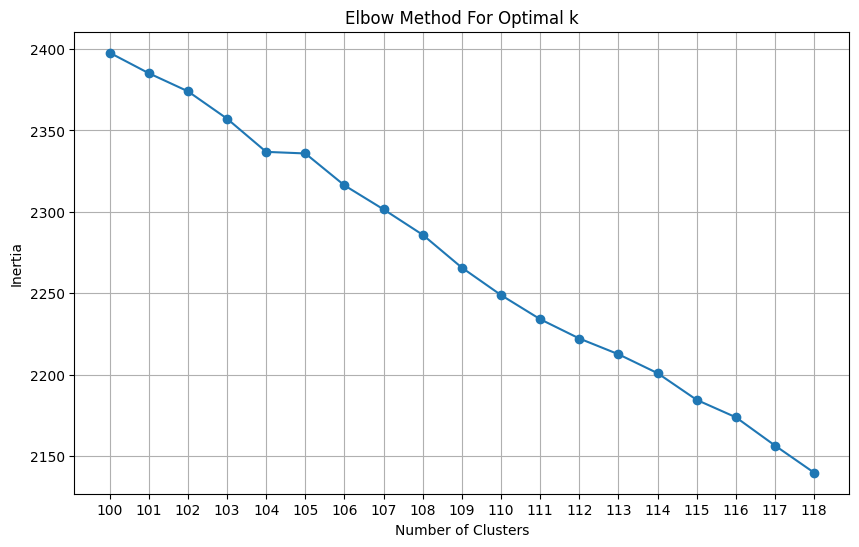

In [14]:
inertia_values = []
cluster_range = range(100, 119)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['stanza_en'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

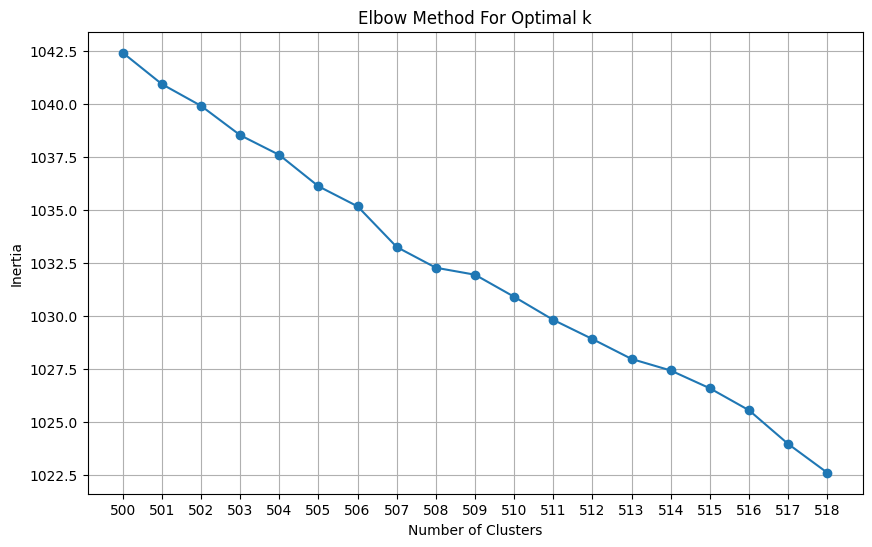

In [15]:
inertia_values = []
cluster_range = range(500, 519)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['stanza_en'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

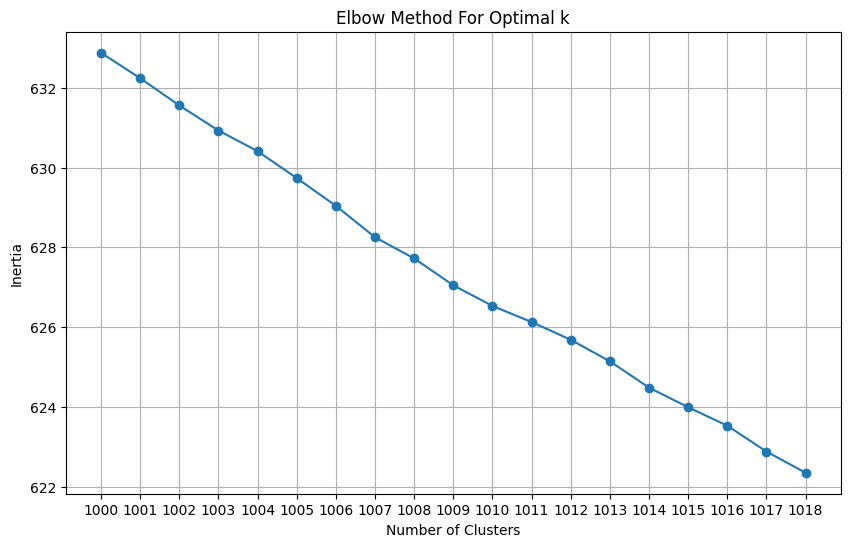

In [16]:
inertia_values = []
cluster_range = range(1000, 1019)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['stanza_en'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

## ANALYSIS CLUSTER 100


Examples of products in Cluster 0:
                                                                  name
1             Buket Bunga Mawar Flanel / Bunga wisuda / Bunga souvenir
5       SUAVECITO wax rambut warna abu abu grey silver pomade gel clay
7                                     Rexus Gaming Chair Kursi RGC-R60
9   Mesin Coding Automatic Cetak Expired Date Produksi MY-380F GOMESIN
10                              Asin amigo/asin kerupuk kualitas super

Examples of products in Cluster 1:
                                                                       name
131  Royco Bumbu Kaldu Rasa Ayam Sapi 220gr 220 gr Penyedap Makanan Masakan
145              GRANOLA 500gr CRISPY ENAK MURAH - CRUNCHY MIX - Less Sugar
259                           SUDOG 375GR WET DOG FOOD-MAKANAN BASAH ANJING
426  500gr SUPER WEIGHT GAIN SUSU PENGGEMUK BADAN PENAMBAH BERAT BADAN BPOM
436        SCHOKO Nutty Nuts Filling & Spread - 250 Gr / Selai Kacang Tanah

Examples of products in Cluster 2:
          

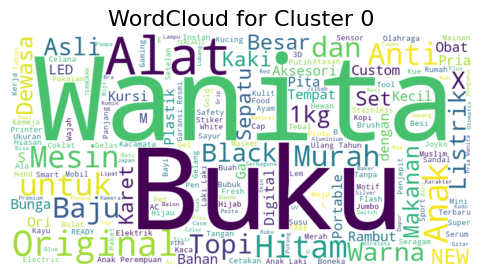

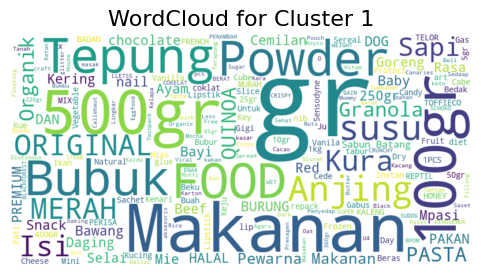

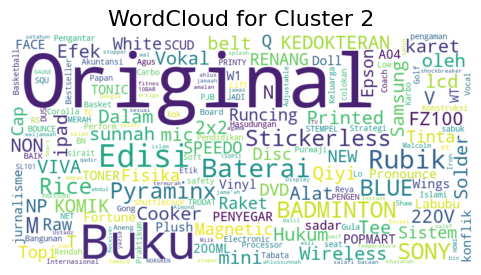

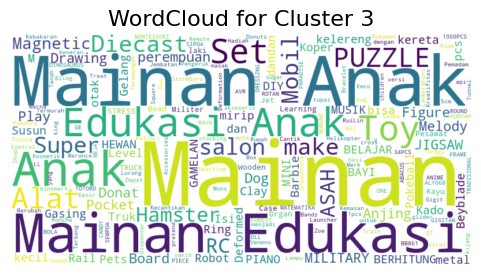

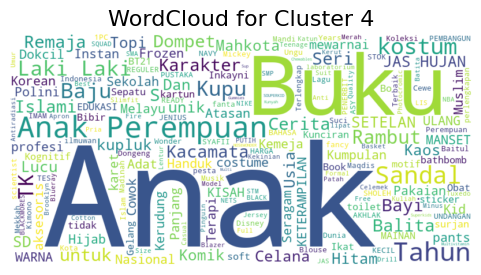

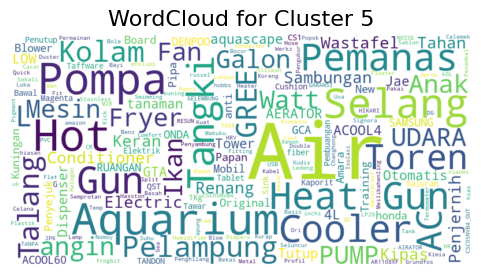

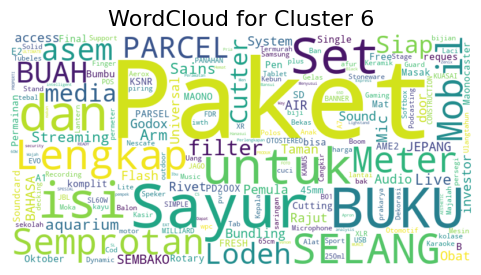

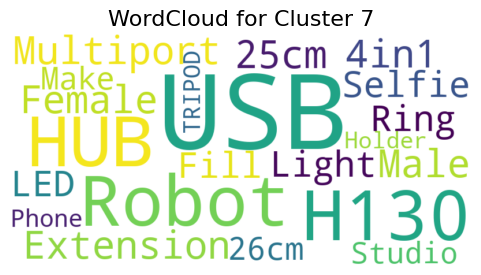

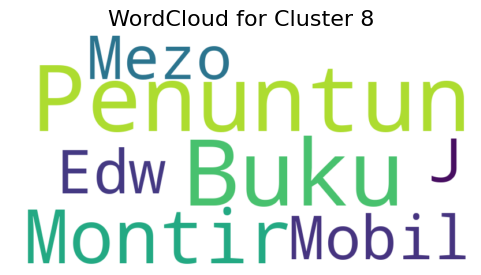

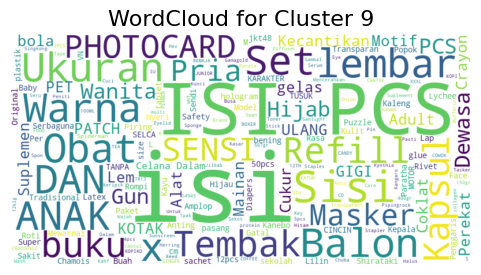

In [ ]:
optimal_k = 104
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster100'] = kmeans.fit_predict(vectorizers['stanza_en'])
show_cluster('cluster100', 10)
show_wordclouds('cluster100', 10)

## ANALYSIS CLUSTER 500


Examples of products in Cluster 0:
                                                                  name
5       SUAVECITO wax rambut warna abu abu grey silver pomade gel clay
9   Mesin Coding Automatic Cetak Expired Date Produksi MY-380F GOMESIN
10                              Asin amigo/asin kerupuk kualitas super
15                                      Victorinox Rapid Peeler 6.0930
18   Yaxiya Gelang Bayi Perempuan Permata Perhiasan Lapis Emas 18K 969

Examples of products in Cluster 1:
                                                           name
157  tanaman air apung amazon frogbit hiasan aquarium aquascape
208    Otomatis Pelampung Air Dispenser Galon Bawah Gea 4 Kabel
252                           Ikan hias air laut Jae jae kuning
499        GREE GTA-ACOOL4 Tower Fan Air Cooler & Humidifier 4L
539   Signora Air Fryer | not philips xiaomi russel hobbs fryer

Examples of products in Cluster 2:
                                                                   name
144       

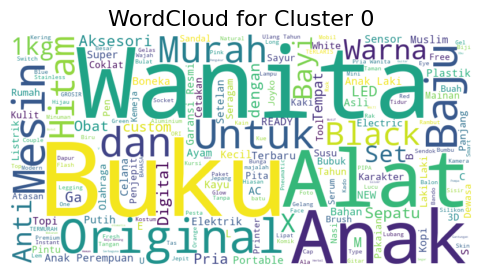

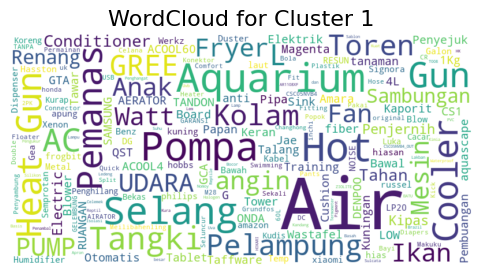

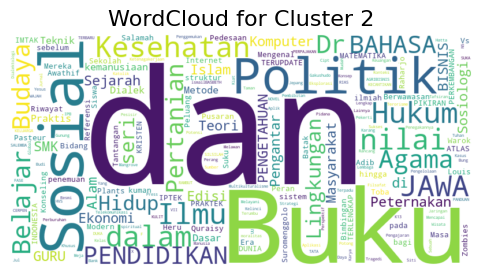

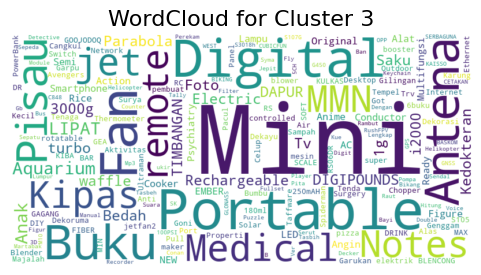

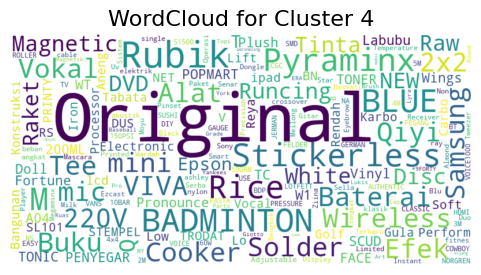

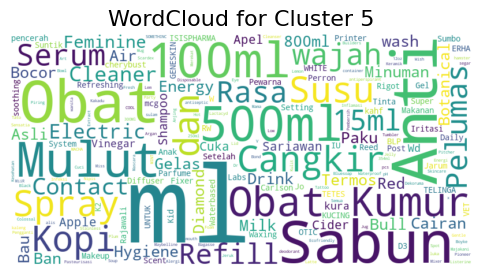

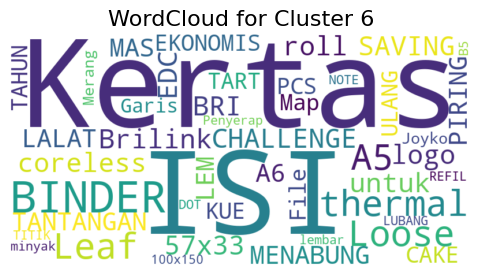

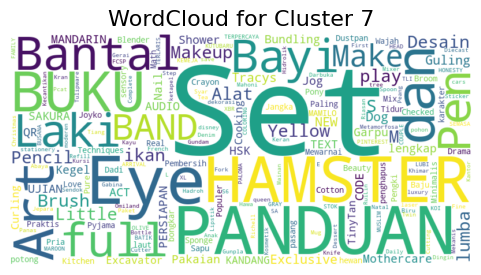

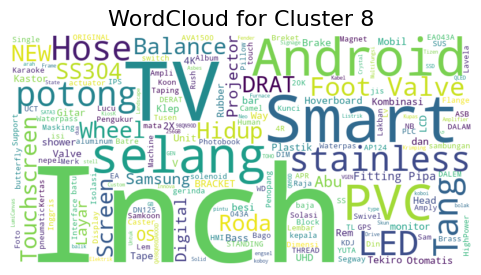

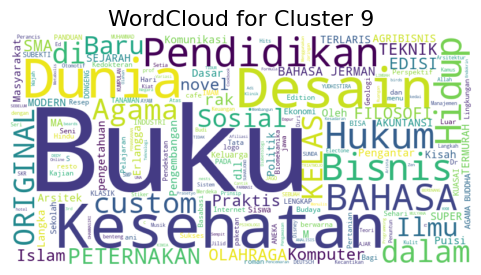

In [19]:
optimal_k = 508
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster500'] = kmeans.fit_predict(vectorizers['stanza_en'])
show_cluster('cluster500', 10)
show_wordclouds('cluster500', 10)

## ANALYSIS CLUSTER 1000


Examples of products in Cluster 0:
                                                                  name
5       SUAVECITO wax rambut warna abu abu grey silver pomade gel clay
9   Mesin Coding Automatic Cetak Expired Date Produksi MY-380F GOMESIN
10                              Asin amigo/asin kerupuk kualitas super
15                                      Victorinox Rapid Peeler 6.0930
18   Yaxiya Gelang Bayi Perempuan Permata Perhiasan Lapis Emas 18K 969

Examples of products in Cluster 1:
                                                           name
157  tanaman air apung amazon frogbit hiasan aquarium aquascape
208    Otomatis Pelampung Air Dispenser Galon Bawah Gea 4 Kabel
252                           Ikan hias air laut Jae jae kuning
499        GREE GTA-ACOOL4 Tower Fan Air Cooler & Humidifier 4L
539   Signora Air Fryer | not philips xiaomi russel hobbs fryer

Examples of products in Cluster 2:
                                                                   name
144       

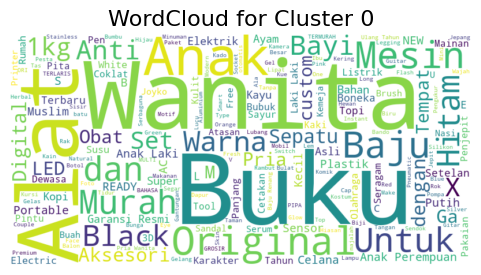

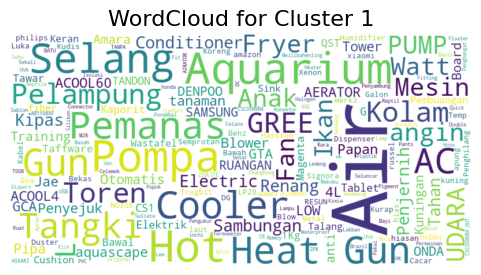

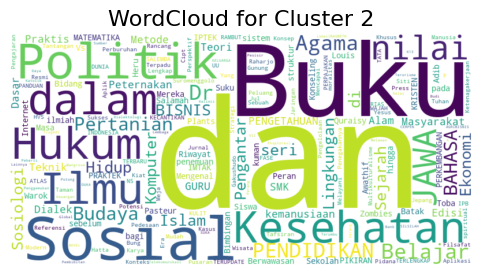

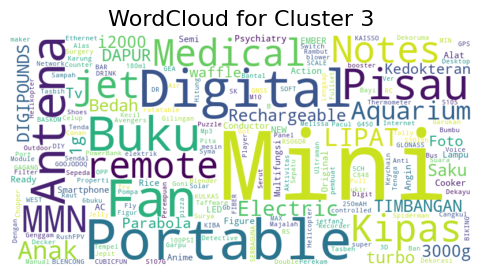

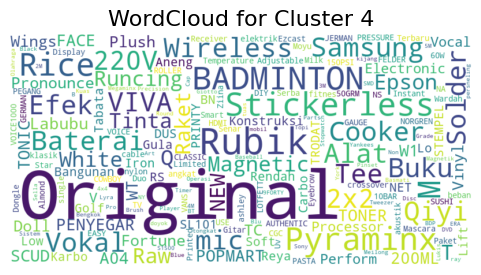

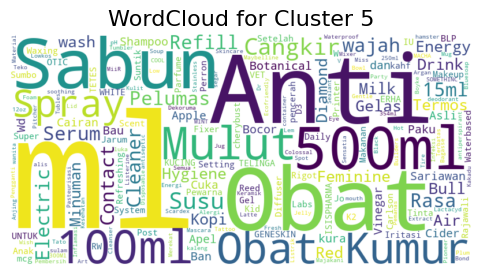

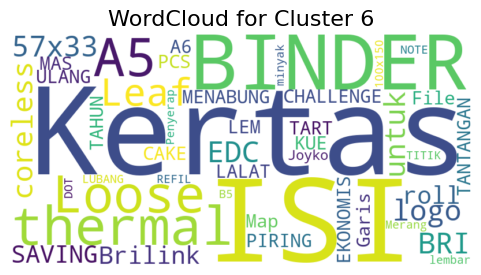

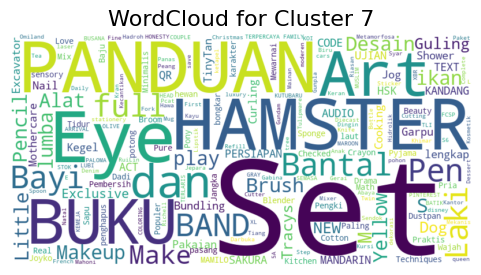

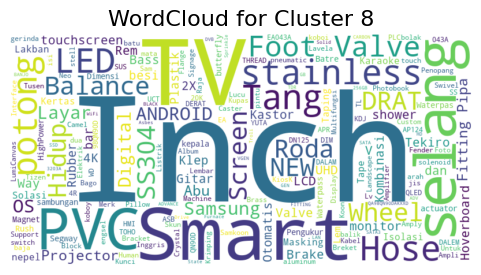

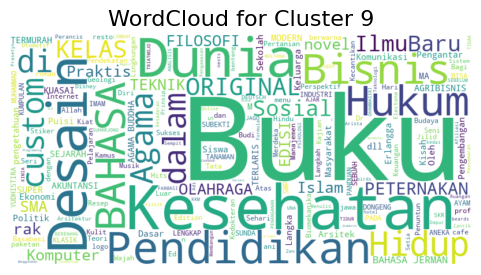

In [20]:
optimal_k = 1007
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster1000'] = kmeans.fit_predict(vectorizers['stanza_en'])
show_cluster('cluster1000', 10)
show_wordclouds('cluster1000', 10)